# Convolutional Neural Network 구현

- MNIST 손글씨 data를 이용하여 CNN을 학습하고 MLP와 결과와 비교 해본다.

##### 학습결과 시각화 함수 정의

In [3]:
import matplotlib.pyplot as plt

# loss 그래프
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [4]:
# accuracy 그래프
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

# MNIST CNN 적용

In [5]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 라이브러리.__version__ ex) np.__version__
print(tf.__version__)
print(keras.__version__)

2.8.2
2.8.0


In [6]:
np.random.seed(0)
tf.random.set_seed(0)

##### data loading

In [7]:
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()
train_image.shape, test_image.shape

11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

##### 하이퍼파라미터, 변수 설정

In [8]:
LEARNING_RATE = 0.001  #학습율
N_EPOCHS = 20          #에폭 횟수
N_BATCHS = 1000        #배치크기

# train/test set의 데이터 개수
N_TRAIN = train_image.shape[0]
N_TEST = test_image.shape[0]

##### 전처리, Dataset 생성
- X
    - uint8을 float32 타입으로 변경.
    - pixcel값 정규화: 0 ~ 1
    - Gray scale에 channel 축이 없는 경우 dummy 축을 늘려준다.
        - 영상처리 convolution layer(Conv2D)는 입력으로 3차원 (height, width, channel) 배열을 받는다.
- Y: onehot encoding

In [9]:
# X: 0 ~ 1 scaling
X_train_tmp = train_image.astype(np.float32)  #uint8->float32
X_train_tmp /= 255.0  # 0 ~ 1 정규화

X_test_tmp = test_image.astype(np.float32)
X_test_tmp /= 255.0

# channel 축을 추가 # (28, 28) -> (28,  28, 1)
X_train = X_train_tmp[..., np.newaxis]
X_test = X_test_tmp[..., np.newaxis]

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [10]:
# y: onehot-encoding
y_train = keras.utils.to_categorical(train_label)
y_test = keras.utils.to_categorical(test_label)

###### Dataset 생성

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(N_TRAIN).batch(N_BATCHS, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCHS)

## Model(Network) 정의
- Feature Extraction(backbone):Convolution Layer
    - block: Convolution + MaxPooling Layer
    - size(height, width) 는 줄이고 channel은 늘리는 방향으로 Layer들을 쌓는다.
    - convolution
        - size: 3 X 3
        - strides: 1
    - max pooling
        - size: 2 X 2
        - strides: 2
        - 위와 같이 지정해 input의 size를 절반으로 줄인다. 
- 분류기
    - Dense Layer 사용        
    - Flatten을 먼저 해야 한다. (Conv의 output-feature map- 3차원 배열)


In [12]:
def create_mnist_model():
    model = keras.Sequential()

    model.add(layers.InputLayer((28, 28, 1))) # input layer. 2D Convolution Layer의 경우 입력데이터는 3차원(h,w,c) 이어야 한다.

    model.add(layers.Conv2D(filters=32,         #필터수
                            kernel_size=(3,3),  #필터크기 (h, w), h와 w가 같을경우 정수로 설정.
                            padding='same',     #padding 설정: "valid"(기본값), "same"
                            strides=(1,1),      #stride설정(가로방향 stride, 세로방향 stride) 둘이 같을 경우 정수. 기본(1,1)
                            activation='relu'   # 활성함수 - convolution 연산이 끝난 결과(Feature map)에 적용할 활성함수.
                            # ,input_shape=(28,28,1)
                            ))
    
    model.add(layers.MaxPool2D(pool_size=(2,2), # Pooling 영역크기. 기본값 (2,2)
                               strides=(2,2a),   # 다음 영역을 얼만큼 떨어진 곳에 잡을 것인지. 기본값: pool_size와 동일하게 잡힌다.
                               padding='same')) 
    # valid(기본): 마지막 남은 것이 pool_size 보다 작으면 버린다. same: pool_size보다 작으면 zero padding을 붙여 max값을 추출한다.

    # filters: 필터개수 - 출력Layer와 가까이 갈 수록(top 단) 더 크게 잡아준다.
    model.add(layers.Conv2D(filters=64,
                            kernel_size=3, # (3,3)
                            padding='same',
                            activation='relu'
                            # strides생략: 기본값 - (1,1)
                            ))
    model.add(layers.MaxPool2D(padding='same'))  # pool_size: (2,2), strides=(2,2) => 기본값

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))


# 추론기
    model.add(layers.Flatten())  # 3차원의 Feature map을 1차원으로 reshape(변환).

    model.add(layers.Dense(units=256, activation='relu'))

# output layer - 다중 분류: unit수-클래스개수, 활성함수: softmax - 클래스별 확률나오돌록 처리.
    model.add(layers.Dense(units=10, activation='softmax'))

    return model

##### 컴파일

In [13]:
model = create_mnist_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [14]:
model.summary()
# convolution layer는 dense layer와 비교해서 파라미터(weight)의 수는 적고 추론시 연산량은 많다.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

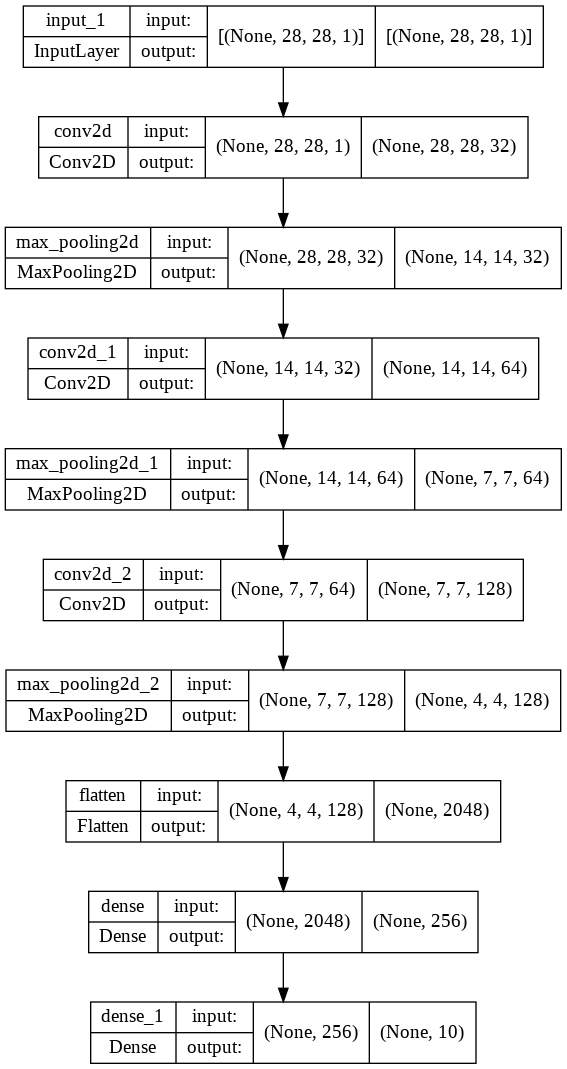

In [15]:
keras.utils.plot_model(model, show_shapes=True)

##### 학습

In [16]:
hist = model.fit(train_dataset, 
                 epochs=N_EPOCHS, 
                 validation_data=test_dataset)

Epoch 1/20
60/60 [==============================] - 15s 38ms/step - loss: 0.6230 - accuracy: 0.8172 - val_loss: 0.1373 - val_accuracy: 0.9569
Epoch 2/20
60/60 [==============================] - 2s 36ms/step - loss: 0.1068 - accuracy: 0.9673 - val_loss: 0.0709 - val_accuracy: 0.9780
Epoch 3/20
60/60 [==============================] - 2s 36ms/step - loss: 0.0689 - accuracy: 0.9786 - val_loss: 0.0576 - val_accuracy: 0.9810
Epoch 4/20
60/60 [==============================] - 2s 37ms/step - loss: 0.0508 - accuracy: 0.9841 - val_loss: 0.0371 - val_accuracy: 0.9879
Epoch 5/20
60/60 [==============================] - 2s 36ms/step - loss: 0.0432 - accuracy: 0.9867 - val_loss: 0.0378 - val_accuracy: 0.9871
Epoch 6/20
60/60 [==============================] - 2s 37ms/step - loss: 0.0340 - accuracy: 0.9893 - val_loss: 0.0274 - val_accuracy: 0.9909
Epoch 7/20
60/60 [==============================] - 2s 37ms/step - loss: 0.0296 - accuracy: 0.9911 - val_loss: 0.0284 - val_accuracy: 0.9911
Epoch 8/20
6

##### 결과시각화

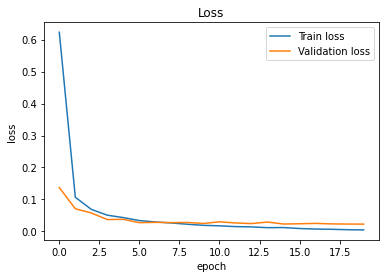

In [17]:
plot_loss(hist)

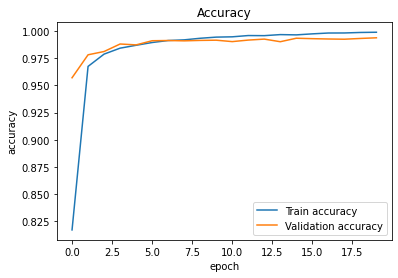

In [18]:
plot_accuracy(hist)

##### 최종검증

In [19]:
loss, acc = model.evaluate(test_dataset)

10/10 [==============================] - 0s 20ms/step - loss: 0.0228 - accuracy: 0.9936


In [20]:
print(loss, acc)

0.022774767130613327 0.9936000108718872


## prediction error가 발생한 example 확인
- test dataset으로 예측한 결과중 틀린 것들을 확인해 본다.

In [22]:
pred = model.predict(X_test)
pred.shape # 0 ~ 9 일 클래스별 확률 추론
pred[0]

array([3.3488539e-13, 8.8453600e-10, 1.3413295e-09, 7.2679677e-07,
       1.7594193e-12, 5.4022992e-13, 3.8587303e-20, 9.9999893e-01,
       5.9453477e-11, 4.1133472e-07], dtype=float32)

In [24]:
pred_label = np.argmax(pred, axis=-1)  # label을 추출
pred_label.shape
pred_label[:3]

array([7, 2, 1])

In [26]:
# 자동완성단축키: shift + space
# 혼동행렬(confusion matrix)
from sklearn.metrics import confusion_matrix

confusion_matrix(test_label, pred_label) 

array([[ 972,    0,    1,    0,    0,    1,    4,    1,    1,    0],
       [   0, 1131,    1,    0,    0,    0,    1,    2,    0,    0],
       [   0,    0, 1028,    0,    1,    0,    0,    3,    0,    0],
       [   0,    0,    0, 1007,    0,    3,    0,    0,    0,    0],
       [   0,    0,    0,    0,  975,    0,    2,    1,    0,    4],
       [   1,    0,    0,    5,    0,  883,    1,    0,    0,    2],
       [   0,    2,    0,    1,    1,    1,  953,    0,    0,    0],
       [   0,    2,    3,    0,    0,    0,    0, 1021,    1,    1],
       [   3,    0,    1,    1,    0,    1,    0,    1,  965,    2],
       [   0,    0,    0,    1,    3,    1,    0,    3,    0, 1001]])

In [28]:
# 틀린 것들의 index
idx = np.where(test_label != pred_label)[0]
idx.shape, idx[:5]

((64,), array([340, 582, 659, 740, 938]))

##### confusion matrix 확인

In [29]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(test_label, pred_label)

array([[ 972,    0,    1,    0,    0,    1,    4,    1,    1,    0],
       [   0, 1131,    1,    0,    0,    0,    1,    2,    0,    0],
       [   0,    0, 1028,    0,    1,    0,    0,    3,    0,    0],
       [   0,    0,    0, 1007,    0,    3,    0,    0,    0,    0],
       [   0,    0,    0,    0,  975,    0,    2,    1,    0,    4],
       [   1,    0,    0,    5,    0,  883,    1,    0,    0,    2],
       [   0,    2,    0,    1,    1,    1,  953,    0,    0,    0],
       [   0,    2,    3,    0,    0,    0,    0, 1021,    1,    1],
       [   3,    0,    1,    1,    0,    1,    0,    1,  965,    2],
       [   0,    0,    0,    1,    3,    1,    0,    3,    0, 1001]])

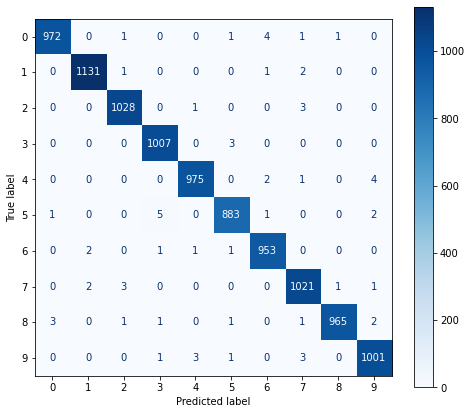

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,7))
ax = plt.gca()

cm = confusion_matrix(test_label, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.show()

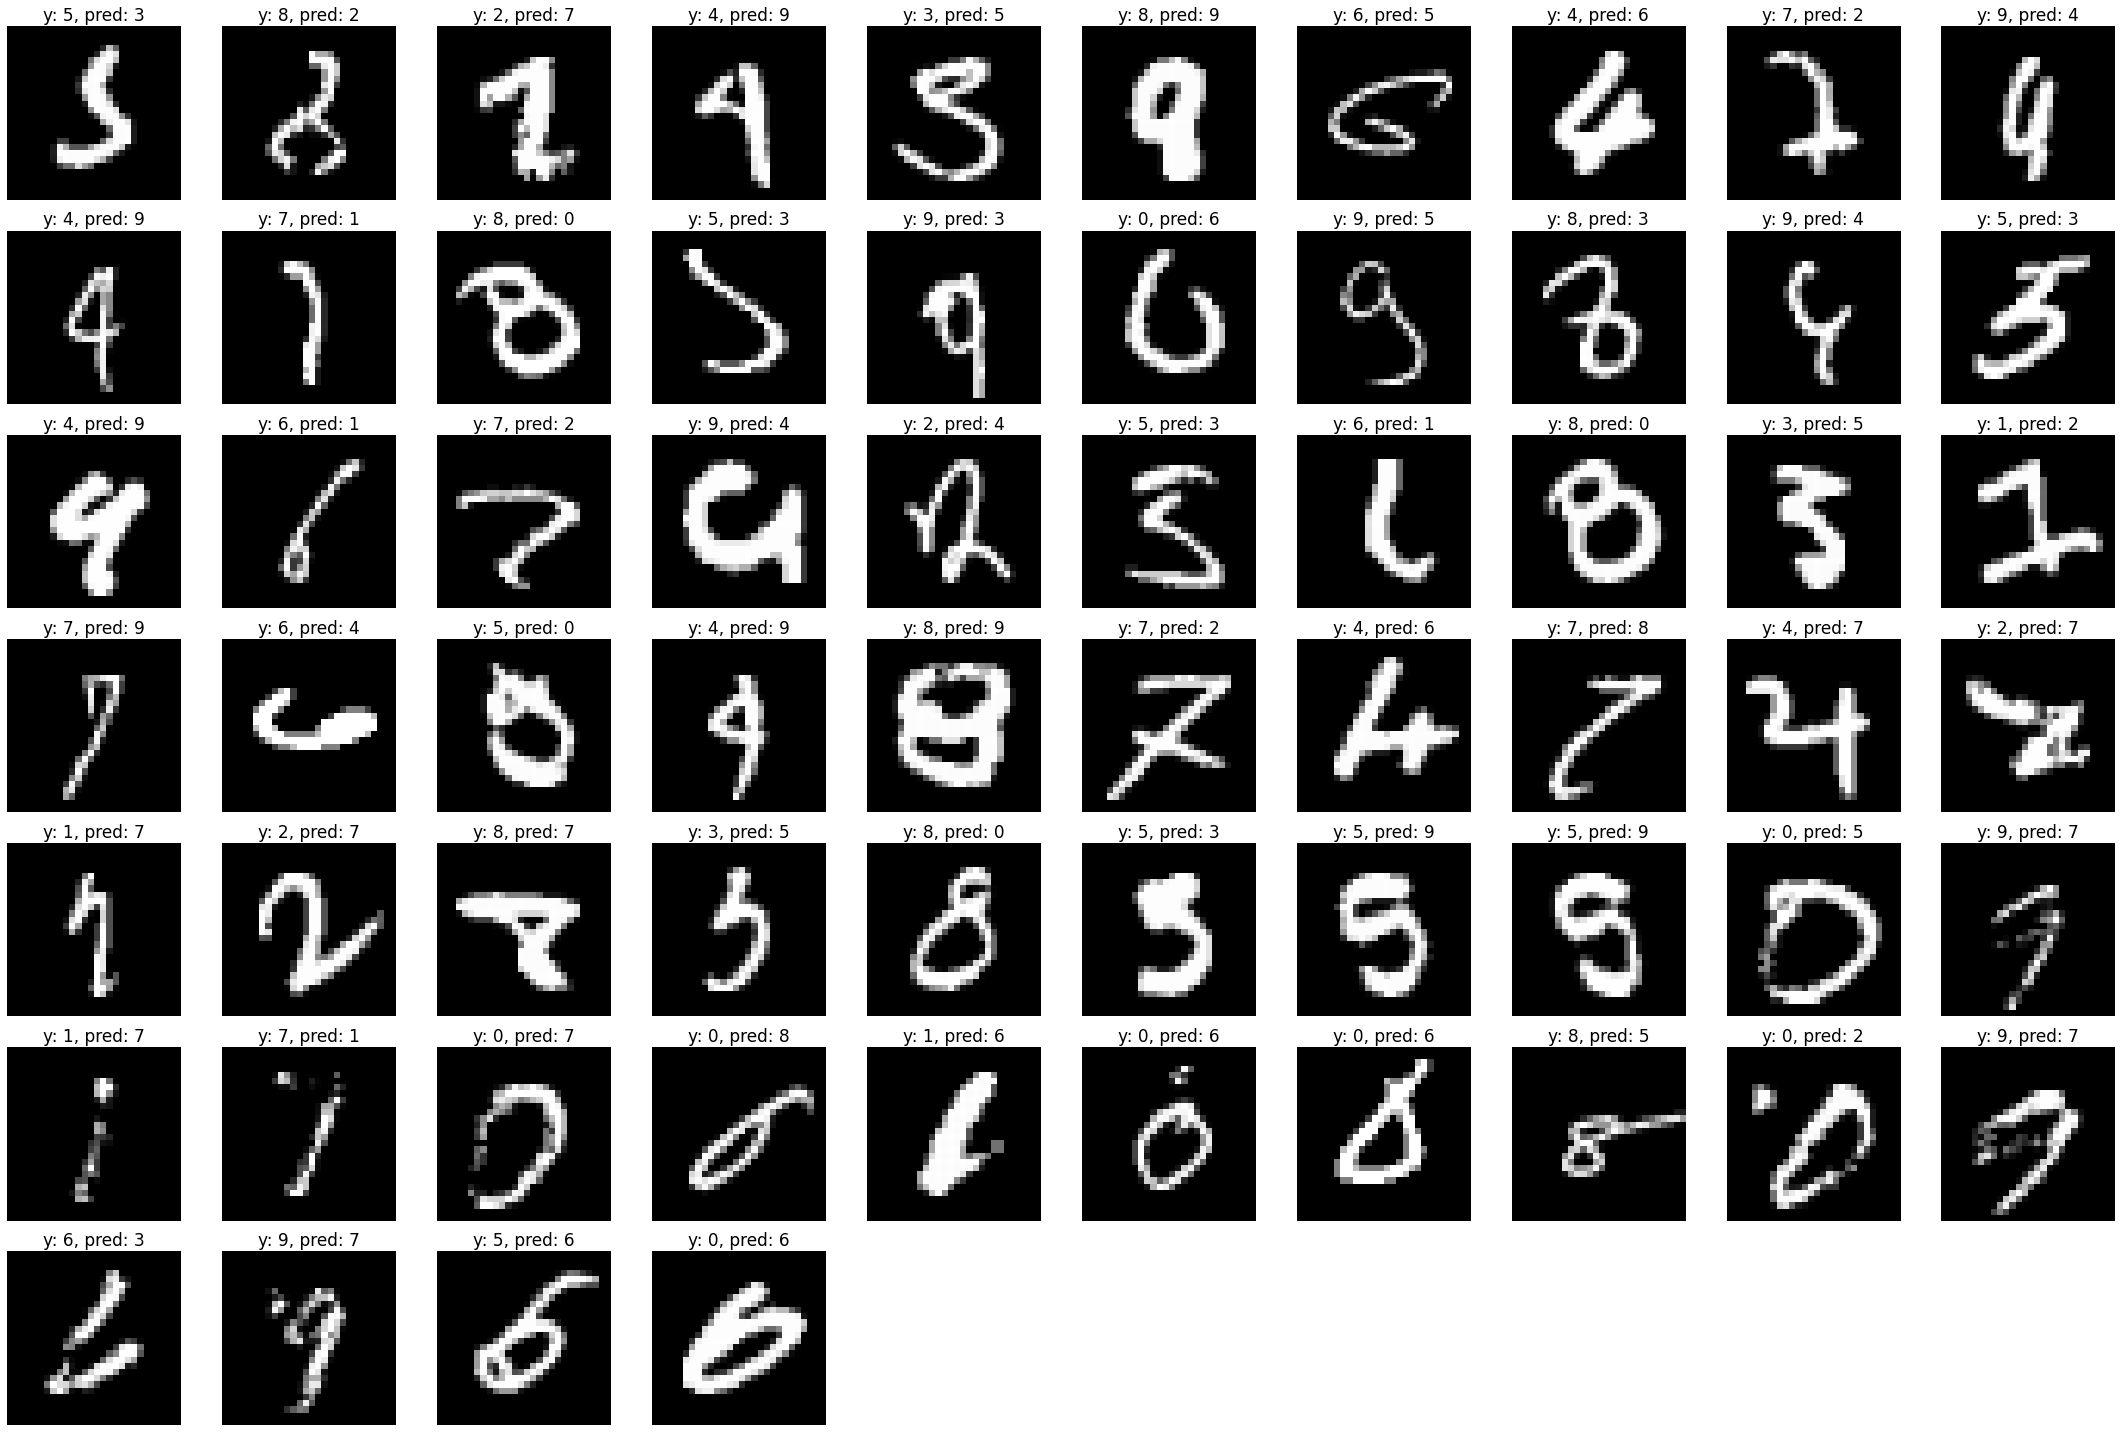

In [36]:
# 틀린 결과 중에 10개 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(30,20))

for i in range(64):  
   
    error_idx = idx[i]
    
    p = pred_label[error_idx]
    y = test_label[error_idx]

    plt.subplot(7, 10, i+1)
    plt.imshow(test_image[error_idx], cmap='gray')
    plt.title("y: {}, pred: {}".format(y, p), fontsize=17)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [42]:
np.round(pred[idx[2]], 4)

array([0.000e+00, 5.900e-02, 8.730e-02, 3.000e-04, 0.000e+00, 0.000e+00,
       0.000e+00, 8.534e-01, 0.000e+00, 0.000e+00], dtype=float32)

# 학습한 모델 파일로 저장

- **무엇을 저장할 지**
    1. Train이 끝난 모델의 파라미터만 저장
    1. 모델 구조와 파라미터 모두 저장

- **저장시점**
    1. Train 완료된 모델을 저장
    1. Callback을 이용해 Train 도중 가장 성능이 좋은 시점의 모델을 저장

## 텐서플로 저장 파일 타입
- checkpoint 
    - 모델의 weight를 저장하기 위한 타입
- SavedModel 
    - 모델의 구조와 파라미터들을 모두 저장하는 타입

## 학습한 Weight (파라미터) 저장 및 불러오기
- 가중치를 저장하여 나중에 재학습 없이 학습된 가중치를 사용할 수 있다.
- 저장
    - `model.save_weights("저장경로")`
- 불러오기
    - `model.load_weights('불러올경로')`
- 저장형식
    - Tensorflow Checkpoint (기본방식)
    - HDF5
        - `save_weights(.., save_format='h5')`
        - 또는 파일 확장자를 h5로 지정한다.

### Checkpoint 으로 저장

##### 저장할 경로 생성및 저장

In [44]:
import os

# 저장할 경로
# 모델들을 저장할 시작 경로
base_dir = "/content/drive/MyDrive/saved_models"  #content/drive/MyDrive -> 구글드라이브경로
# 현재 모델의 weight를 저장할 경로
mnist_weight_dir = os.path.join(base_dir, "mnist_weight") # 두경로를 합친 경로를 문자열로 반환.
print(mnist_weight_dir)

# 디렉토리 생성.
if not os.path.isdir(mnist_weight_dir):  # mnist_weight_dir 디렉토리가 없다면
    os.makedirs(mnist_weight_dir) #만들어라.

# 저장할 weight 파일의 경로. checkpoint파일의 확장자는 보통 ckpt로 준다.
weight_file_path = os.path.join(mnist_weight_dir, "mnist_weight.ckpt")

print(weight_file_path)

/content/drive/MyDrive/saved_models/mnist_weight
/content/drive/MyDrive/saved_models/mnist_weight/mnist_weight.ckpt


In [45]:
# 모델의 파라미터들을 저장.
model.save_weights(weight_file_path)

In [46]:
# 저장된 파라미터 불러오기.
# 1. 모델을 생성
# 2. 파일로 저장된 파라미터를 모델에 파라미터로 덮어쓰기.(load)
new_model1 = create_mnist_model()
new_model1.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [47]:
# 새로 만든 모델로 평가
new_model1.evaluate(test_dataset)

10/10 [==============================] - 0s 18ms/step - loss: 2.3066 - accuracy: 0.0980


[2.306602954864502, 0.09799999743700027]

In [48]:
# 생성한 모델에 저장된 파라미터 덮어쓰기.
new_model1.load_weights(weight_file_path)

In [49]:
new_model1.evaluate(test_dataset)

10/10 [==============================] - 0s 18ms/step - loss: 0.0228 - accuracy: 0.9936


[0.022774767130613327, 0.9936000108718872]

### h5 형식으로 저장

In [50]:
# 저장할 디렉토리 생성
weight_h5_dir = os.path.join(base_dir, "mnist_weight_h5")
if not os.path.isdir(weight_h5_dir):
    os.makedirs(weight_h5_dir, exist_ok=True)

# 파일경로
weight_h5_path = os.path.join(weight_h5_dir, "mnist_weight.h5")

In [51]:
model.save_weights(weight_h5_path, save_format='h5')

In [52]:
new_model2 = create_mnist_model()
new_model2.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [53]:
new_model2.evaluate(test_dataset)

10/10 [==============================] - 0s 20ms/step - loss: 2.3001 - accuracy: 0.0936


[2.3000829219818115, 0.09359999746084213]

In [54]:
new_model2.load_weights(weight_h5_path)

In [55]:
new_model2.evaluate(test_dataset)

10/10 [==============================] - 0s 19ms/step - loss: 0.0228 - accuracy: 0.9936


[0.022774767130613327, 0.9936000108718872]

## 전체 모델 저장하고 불러오기
- https://www.tensorflow.org/guide/keras/save_and_serialize?hl=ko
- 저장
    - `model.save('저장할디렉토리')`
- 불러오기
    - `tf.keras.models.load_model('저장된디렉토리')`
- 저장 형식
    - Tensorflow SavedModel 형식(기본방식)
        - 모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb 에 저장된다.
        - 파라미터는 variables/ 디렉토리에 저장된다.
        - https://www.tensorflow.org/guide/saved_model?hl=ko#the_savedmodel_format_on_disk
    - HDF5 형식
        - `save(..., save_format='h5')` 
        - 또는 파일의 확장자를 h5로 지정한다.

###  Saved Model 형식으로 모델 저장
- 경로(디렉토리) 만 지정한다.

In [56]:
# 모델을 저장할 디렉토리 경로
mnist_model_dir = os.path.join(base_dir, 'mnist_model')
print(mnist_model_dir, type(mnist_model_dir))
# 디렉토리 생성
if not os.path.isdir(mnist_model_dir):
    os.mkdir(mnist_model_dir) 

/content/drive/MyDrive/saved_models/mnist_model <class 'str'>


In [57]:
model.save(mnist_model_dir)

In [58]:
new_model3 = keras.models.load_model(mnist_model_dir)

new_model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [59]:
new_model3.evaluate(test_dataset)

10/10 [==============================] - 0s 19ms/step - loss: 0.0228 - accuracy: 0.9936


[0.022774767130613327, 0.9936000108718872]

### H5 형식으로 모델 저장

In [60]:
# 저장할 디렉토리 경로 
model_h5_dir = os.path.join(base_dir, 'mnist_model_h5')
# 디렉토리 생성
if not os.path.join(model_h5_dir):
    os.makedirs(model_h5_dir, exist_ok=True)
# 저장할 파일 경로
model_h5_path = os.path.join(model_h5_dir, "mnist_model.h5")

In [61]:
model.save(model_h5_path, save_format='h5')

In [62]:
new_model4 = keras.models.load_model(model_h5_path)

new_model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [63]:
new_model4.evaluate(test_dataset)

10/10 [==============================] - 0s 18ms/step - loss: 0.0228 - accuracy: 0.9936


[0.022774767130613327, 0.9936000108718872]

## Callback을 사용한 모델 저장 및 Early Stopping
- callback은 학습하는 도중 특정 이벤트 발생시 호출되는 다양한 함수를 제공하여 자동화 처리를 지원한다. (cf: 프로그래밍의 콜백함수)
- 다양한 콜백 클래스가 제공된다.
    - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
- ### ModelCheckpoint
    - 각 epoch 마다 학습한 모델과 weight(또는 weight만)를 저장한다. 
    - 지정한 평가지표(예:validation loss)가 가장 좋을 때 모델과 weight만 저장할 수 있다.
    - 주요 파라미터
        - `save_weights_only=True`: True: 파라미터(weight)만 저장한다. False: 모델구조와 파라미터 모두 저장한다.
        - `save_best_only=True`: 학습중 성능이 개선될 때만 저장한다. (False:기본값 - 모든 에폭마다 저장한다.)
- ### EarlyStopping
    - Validation set에 대한 평가지표가  더 이상 개선되지 않을 때 학습을 자동으로 멈추는 callback
    - 주요 파라미터
        - `monitor`: 모니터링할 평가지표 지정. (ex: accuracy)
        - `patience`: epoch 수 지정. validation 평가 지표가 개선이 안되더라도 지정한 epoch만큼 반복한다. 지정한 epoch만큼 반복 후에도 개선이 되지 않으면 중단한다. 

- **callback 객체들을 리스트로 묶은 뒤 fit()의 callbacks 매개변수에 전달한다.**

In [65]:
# 모델 생성
# 컴파일
model2 = create_mnist_model()
model2.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [66]:
# 모델의 가중치를 저장할 디렉토리 경로
checkpoint_save_dir = os.path.join(base_dir, 'mnist_callback')
if not os.path.isdir(checkpoint_save_dir):
    os.mkdir(checkpoint_save_dir)
# 모델의 가중치파일 경로
saved_model_path = os.path.join(checkpoint_save_dir, 'mnist_ckpt2')
# checkpoint_save_file = os.path.join(checkpoint_save_dir, 'mnist_ckpt')

In [67]:
# 모델 저장을 위한 callback
mc_callback = keras.callbacks.ModelCheckpoint(filepath=saved_model_path,   # 저장할 경로
                          save_best_only=True,    #기본: False - 매 에폭마다 저장, True - 성능이 개선된 에폭만 저장.
#                           save_weights_only=True, # 기본:False - 모델구조+weight 저장. True: Weights만 저장.
                          monitor='val_loss',  # save_best_only=True한 경우 어떤 지표를 확인할 것인지 지정.
                          verbose=1) #기록.

In [68]:
# 조기 학습 종료를 위한 callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',  # 지표개선을 확인할 평가지표.
                                            patience=5,          # 몇 에폭까지 참을 것인지 (개선되길 기다릴 것인지.)
                                            verbose=1)           #로그.

In [69]:
hist = model2.fit(train_dataset, epochs=20, validation_data=test_dataset,
                  callbacks=[mc_callback, es_callback])

Epoch 1/20
59/60 [============================>.] - ETA: 0s - loss: 0.6530 - accuracy: 0.8139
Epoch 1: val_loss improved from inf to 0.15033, saving model to /content/drive/MyDrive/saved_models/mnist_callback/mnist_ckpt2
60/60 [==============================] - 4s 54ms/step - loss: 0.6446 - accuracy: 0.8163 - val_loss: 0.1503 - val_accuracy: 0.9538
Epoch 2/20
59/60 [============================>.] - ETA: 0s - loss: 0.1098 - accuracy: 0.9664
Epoch 2: val_loss improved from 0.15033 to 0.07890, saving model to /content/drive/MyDrive/saved_models/mnist_callback/mnist_ckpt2
60/60 [==============================] - 3s 50ms/step - loss: 0.1093 - accuracy: 0.9666 - val_loss: 0.0789 - val_accuracy: 0.9744
Epoch 3/20
59/60 [============================>.] - ETA: 0s - loss: 0.0712 - accuracy: 0.9782
Epoch 3: val_loss improved from 0.07890 to 0.05040, saving model to /content/drive/MyDrive/saved_models/mnist_callback/mnist_ckpt2
60/60 [==============================] - 3s 50ms/step - loss: 0.0710 

In [70]:
new_model5 = keras.models.load_model(saved_model_path)

In [71]:
new_model5.evaluate(test_dataset)

10/10 [==============================] - 0s 20ms/step - loss: 0.0224 - accuracy: 0.9927


[0.022424062713980675, 0.9926999807357788]